In [48]:

import pylabnet.hardware.awg.zi_hdawg as zi_hdawg
from pylabnet.utils.logging.logger import LogClient

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import time

from IPython.display import clear_output, display

import pyvisa
from pylabnet.utils.logging.logger import LogClient
from pylabnet.network.client_server import agilent_e4405B
import pylabnet.hardware.spectrum_analyzer.agilent_e4405B as sa_hardware


import itertools as it
import pandas as pd
import seaborn as sns

from pylabnet.utils.logging.logger import LogService
from pylabnet.network.core.generic_server import GenericServer
import os
import sys
from pylabnet.utils.iq_upconversion.optimizer import IQOptimizer
from pylabnet.utils.iq_upconversion.iq_calibration import IQ_Calibration
import pylabnet.utils.iq_upconversion.iq_upconversion_misc as ium
from pylabnet.network.client_server import HMC_T2220

In [3]:
dev_id = 'dev8227'

# Instantiate
logger = LogClient(
    host='140.247.189.82',
    port=29804,
    module_tag=f'ZI HDAWG {dev_id}'
)

In [4]:
# Instantiate Hardware class
hd = zi_hdawg.Driver(dev_id, logger)

# Select channel grouping
hd.set_channel_grouping(0)

hd.enable_output(2)
hd.enable_output(3)

In [6]:
# Connect to MW source client
mw_client = HMC_T2220.Client(
    host='140.247.189.82',
    port=33509
)

In [10]:
# Check that MW source is set to correct power
# mw_client.output_on()
pow = 25  # -20 dBm
mw_client.set_power(pow)
mw_client.set_freq(10E9)
mw_client.is_output_on()
mw_client.get_power()
mw_client.output_on()

In [8]:
sa = agilent_e4405B.Client(
    host='140.247.189.82',
    port=19013
)

# Reset spectrum analzyer
sa.write('*RST')

(6, <StatusCode.success: 0>)

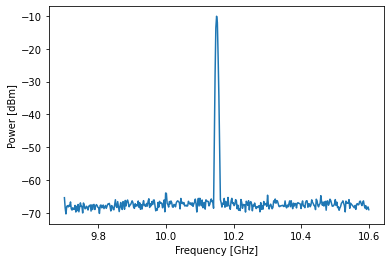

In [16]:
sa.set_center_frequency(10.15E9)
sa.set_frequency_span(900E6)
sa.set_reference_level(-10)
sa.plot_trace()

In [18]:
iq_calibration = IQ_Calibration()
#iq_calibration.run_calibration("12_25_2020_cal.csv", mw_client, hd, sa, 9E9, 12.5E9, 36, 50E6, 500E6, 10, 25, 0.75)
iq_calibration.load_calibration("C:\\Users\\Brain\\pylabnet\\12_25_2020_cal.csv")

[Text(0.5, 194.0937499999998, 'IF Freq (Hz)'),
 Text(69.0, 0.5, 'LO Freq (Hz)'),
 Text(0.5, 1.0, 'DC Offset Q')]

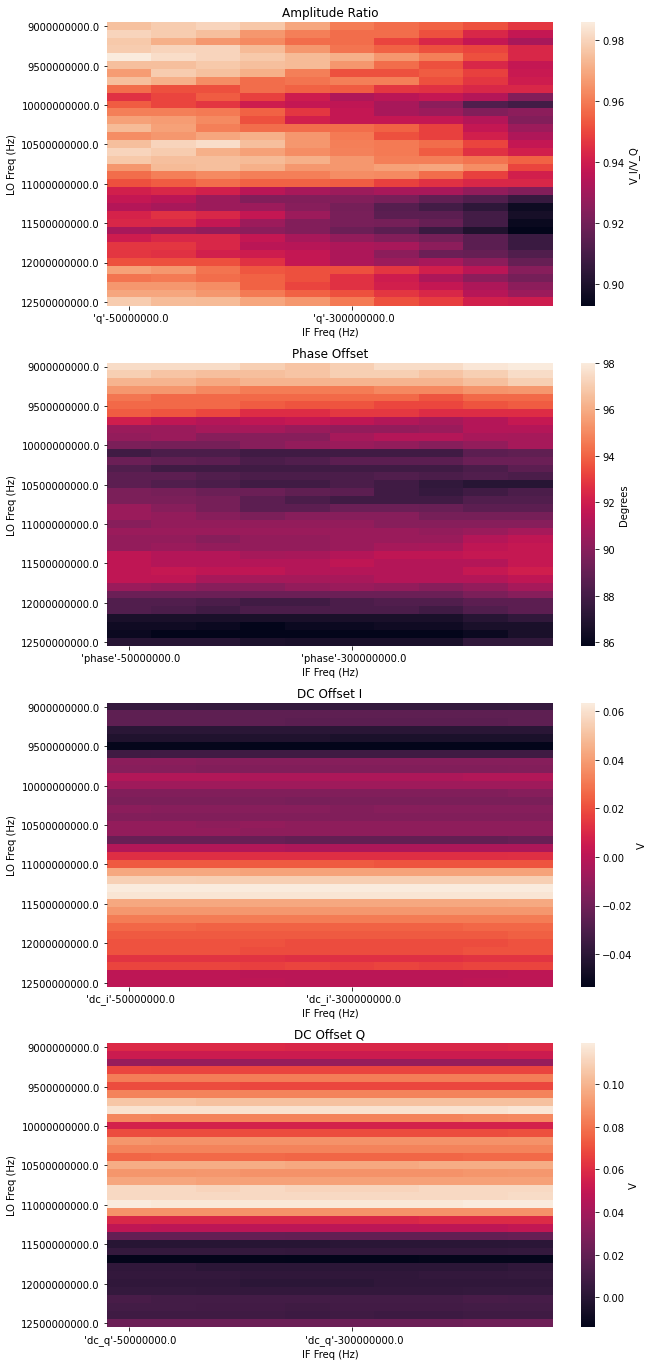

In [37]:
fig, axs = plt.subplots(4, 1, figsize=(10, 24))
axs[0] = sns.heatmap(iq_calibration.q, ax=axs[0], xticklabels=5,  yticklabels=5,  cbar_kws={'label': 'V_I/V_Q'})
axs[0].set(xlabel='IF Freq (Hz)', ylabel='LO Freq (Hz)', title='Amplitude Ratio')

axs[1] = sns.heatmap(iq_calibration.phase, ax=axs[1], xticklabels=5,  yticklabels=5,  cbar_kws={'label': 'Degrees'})
axs[1].set(xlabel='IF Freq (Hz)', ylabel='LO Freq (Hz)', title='Phase Offset')

axs[2] = sns.heatmap(iq_calibration.dc_i, ax=axs[2], xticklabels=5,  yticklabels=5,  cbar_kws={'label': 'V'})
axs[2].set(xlabel='IF Freq (Hz)', ylabel='LO Freq (Hz)', title='DC Offset I')

axs[3] = sns.heatmap(iq_calibration.dc_q, ax=axs[3], xticklabels=5,  yticklabels=5,  cbar_kws={'label': 'V'})
axs[3].set(xlabel='IF Freq (Hz)', ylabel='LO Freq (Hz)', title='DC Offset Q')

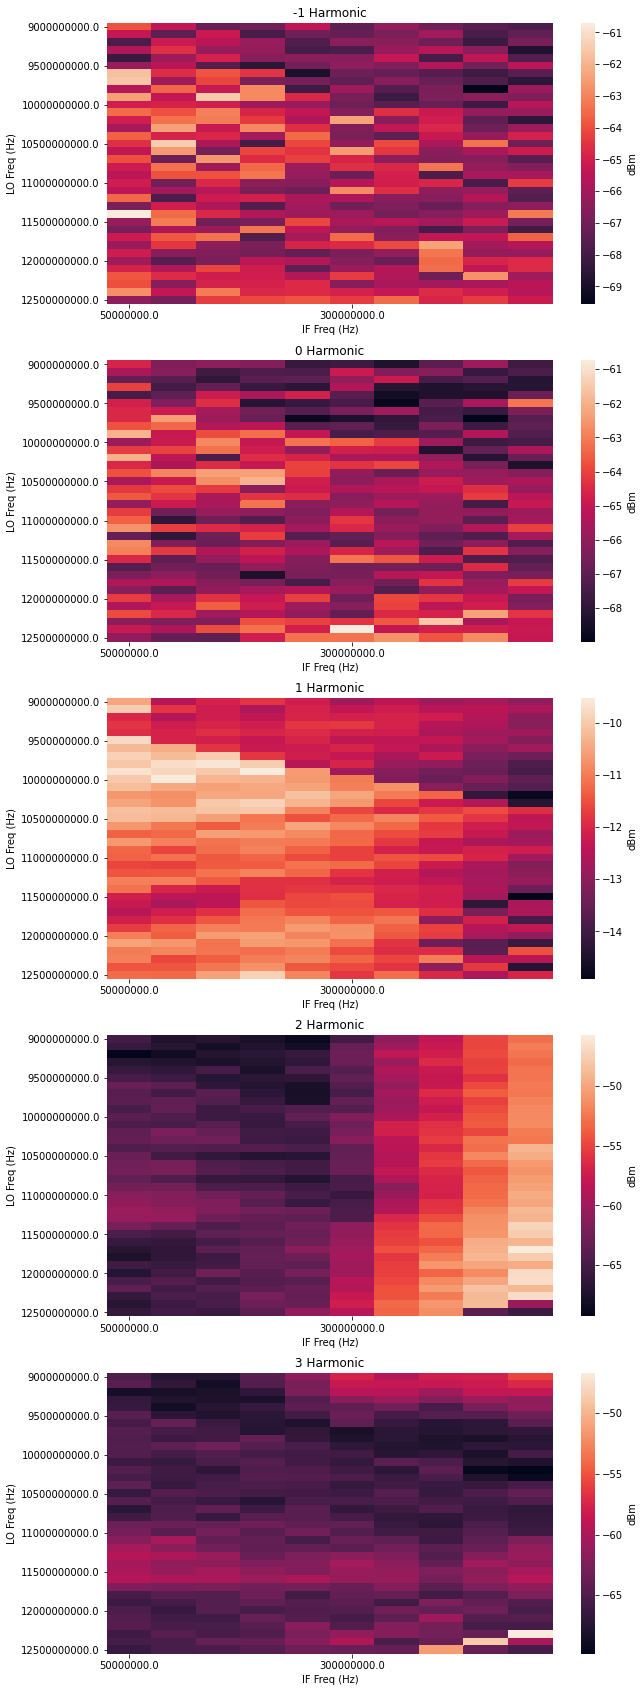

In [45]:
fig, axs = plt.subplots(5, 1, figsize=(10, 30))

for i in range(5):
    axs[i] = sns.heatmap(iq_calibration.harms.iloc[:, i].unstack(), ax=axs[i], xticklabels=5,  yticklabels=5,  cbar_kws={'label': 'dBm'})
    axs[i].set(xlabel='IF Freq (Hz)', ylabel='LO Freq (Hz)', title=str(i-1) + ' Harmonic')



In [114]:
#Now doing a power sweep
lo_freq = 12E9
if_freq = 100E6
mw_client.set_freq(lo_freq)
sa.set_center_frequency(lo_freq+if_freq)
sa.set_frequency_span(if_freq*6)
sa.set_reference_level(-9)
volts = np.linspace(0.01, 0.75)
harms = np.zeros([len(volts), 5])
for i in range(len(volts)):
    iq_calibration.IF_volt = volts[i]
    iq_calibration.set_optimal_hdawg_values(hd, if_freq, lo_freq)
    time.sleep(2)
    harms[i, :] = ium.get_power_at_harmonics(sa, lo_freq, if_freq, [-1, 0, 1, 2, 3])
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


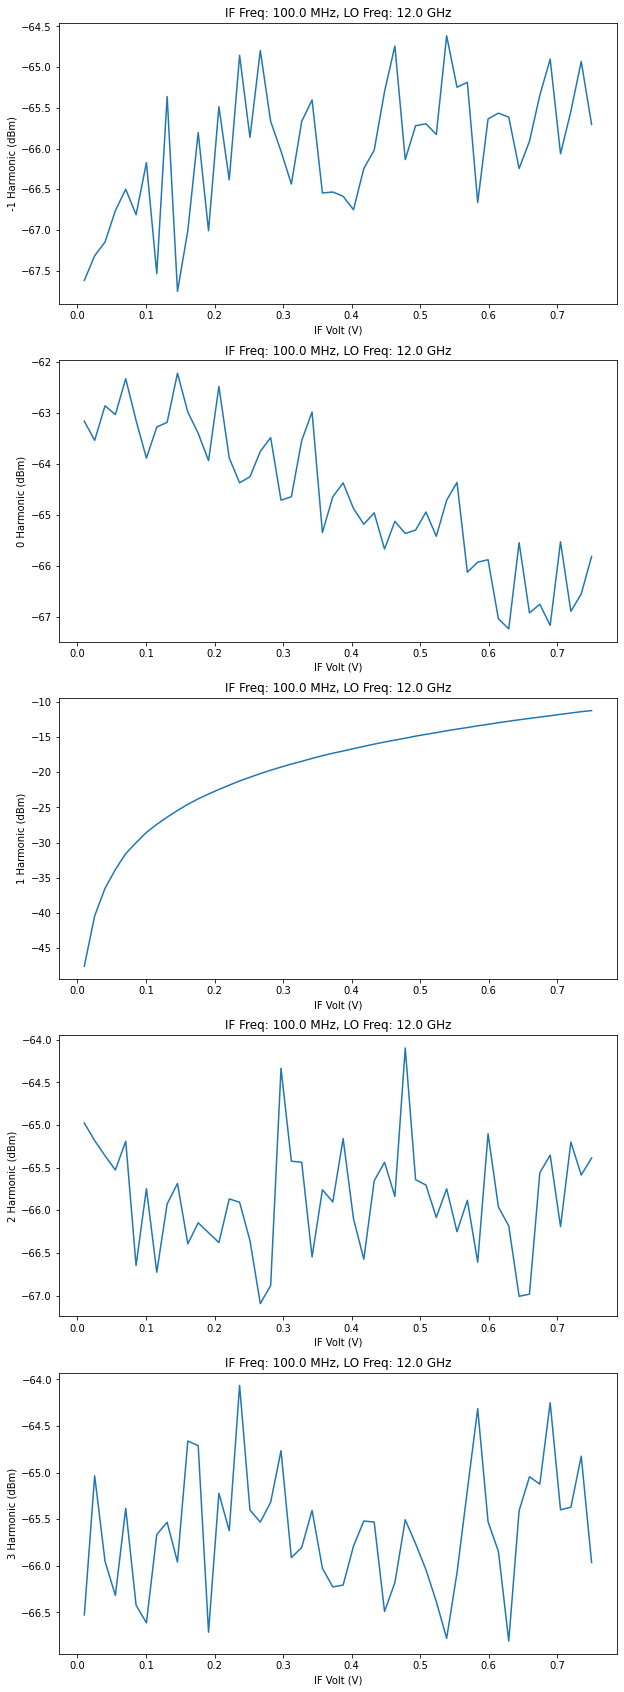

In [115]:
#Plotting power sweep
fig, axs = plt.subplots(5, 1, figsize=(10, 30))

for i in range(5):
    axs[i].plot(volts, harms[:, i])
    axs[i].set(xlabel='IF Volt (V)', ylabel=str(i-1) + ' Harmonic (dBm)', title='IF Freq: ' + str(if_freq/1E6) +  ' MHz, LO Freq: ' + str(lo_freq/1E9) + ' GHz')

In [125]:
#Now doing a IF Frequency sweep
lo_freq = 10E9
if_freqs = np.linspace(150E6, 250E6)
mw_client.set_freq(lo_freq)
harms = np.zeros([len(if_freqs), 5])
for i in range(len(if_freqs)):
    if_freq = float(if_freqs[i])
    sa.set_center_frequency(lo_freq+if_freq)
    sa.set_frequency_span(if_freq*6)
    sa.set_reference_level(-9)
    iq_calibration.IF_volt = 0.75
    iq_calibration.set_optimal_hdawg_values(hd, if_freq, lo_freq)
    time.sleep(2)
    harms[i, :] = ium.get_power_at_harmonics(sa, lo_freq, if_freq, [-1, 0, 1, 2, 3])
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


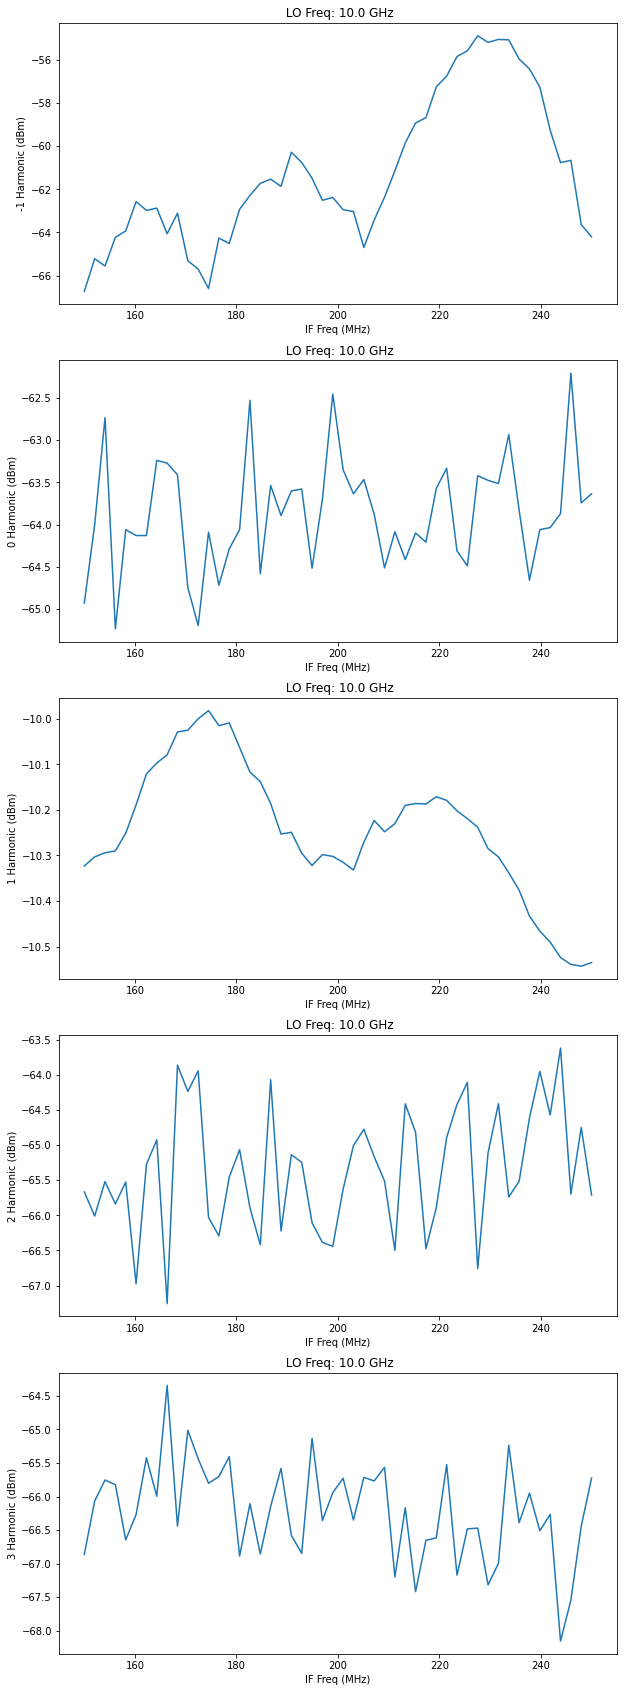

In [126]:
#Plotting power sweep
fig, axs = plt.subplots(5, 1, figsize=(10, 30))

for i in range(5):
    axs[i].plot(if_freqs/1E6, harms[:, i])
    axs[i].set(xlabel='IF Freq (MHz)', ylabel=str(i-1) + ' Harmonic (dBm)', title=' LO Freq: ' + str(lo_freq/1E9) + ' GHz')

In [140]:
#Now doing a IF Frequency sweep
lo_freqs = np.linspace(10E9, 11E9, num=101)
if_freq = 250E6

sa.set_frequency_span(if_freq*6)
sa.set_reference_level(-9)
harms = np.zeros([len(lo_freqs), 5])
for i in range(len(lo_freqs)):
    lo_freq = float(lo_freqs[i])
    mw_client.set_freq(lo_freq)
    sa.set_center_frequency(lo_freq+if_freq)
    iq_calibration.IF_volt = 0.75
    iq_calibration.set_optimal_hdawg_values(hd, if_freq, lo_freq)
    time.sleep(2)
    harms[i, :] = ium.get_power_at_harmonics(sa, lo_freq, if_freq, [-1, 0, 1, 2, 3])
    print(i, lo_freqs[i])

0 10000000000.0
1 10010000000.0
2 10020000000.0
3 10030000000.0
4 10040000000.0
5 10050000000.0
6 10060000000.0
7 10070000000.0
8 10080000000.0
9 10090000000.0
10 10100000000.0
11 10110000000.0
12 10120000000.0
13 10130000000.0
14 10140000000.0
15 10150000000.0
16 10160000000.0
17 10170000000.0
18 10180000000.0
19 10190000000.0
20 10200000000.0
21 10210000000.0
22 10220000000.0
23 10230000000.0
24 10240000000.0
25 10250000000.0
26 10260000000.0
27 10270000000.0
28 10280000000.0
29 10290000000.0
30 10300000000.0
31 10310000000.0
32 10320000000.0
33 10330000000.0
34 10340000000.0
35 10350000000.0
36 10360000000.0
37 10370000000.0
38 10380000000.0
39 10390000000.0
40 10400000000.0
41 10410000000.0
42 10420000000.0
43 10430000000.0
44 10440000000.0
45 10450000000.0
46 10460000000.0
47 10470000000.0
48 10480000000.0
49 10490000000.0
50 10500000000.0
51 10510000000.0
52 10520000000.0
53 10530000000.0
54 10540000000.0
55 10550000000.0
56 10560000000.0
57 10570000000.0
58 10580000000.0
59 1059

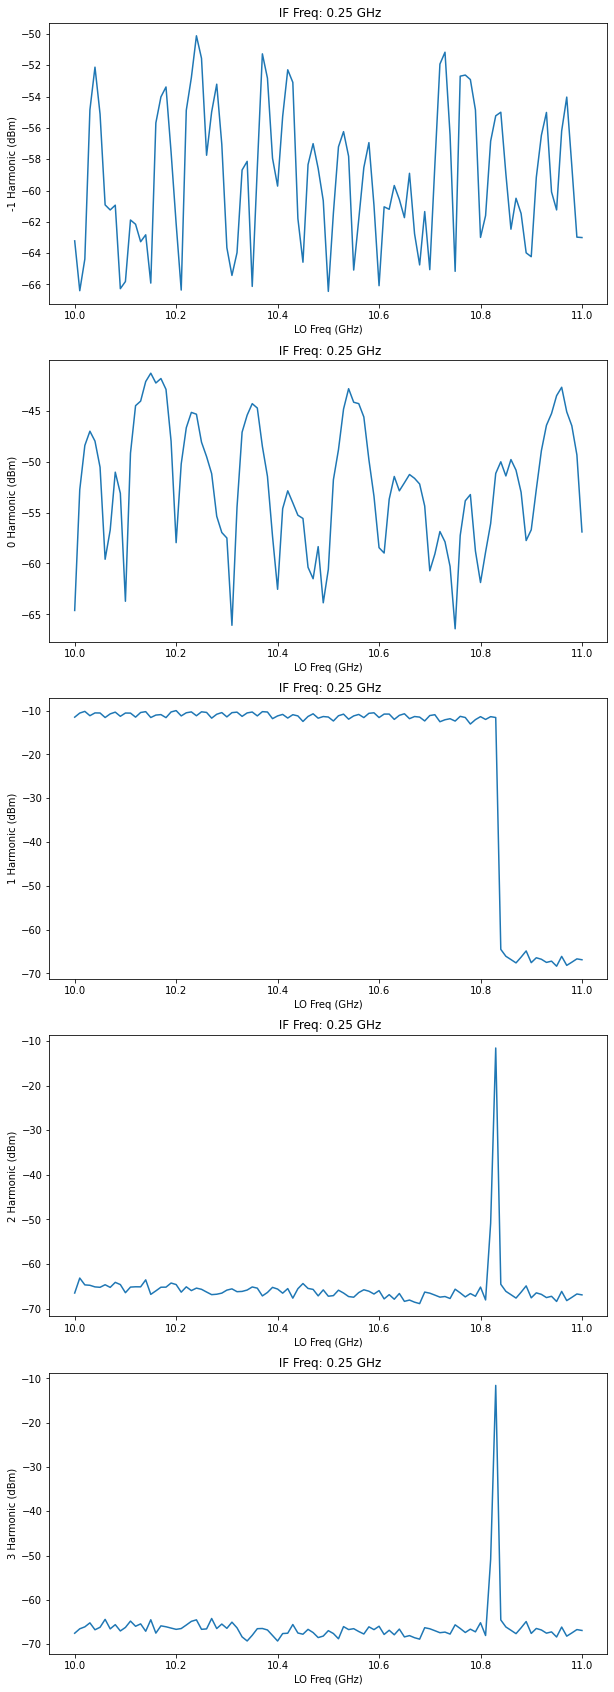

In [141]:
#Plotting power sweep
fig, axs = plt.subplots(5, 1, figsize=(10, 30))

for i in range(5):
    axs[i].plot(lo_freqs/1E9, harms[:, i])
    axs[i].set(xlabel='LO Freq (GHz)', ylabel=str(i-1) + ' Harmonic (dBm)', title=' IF Freq: ' + str(if_freq/1E9) + ' GHz')

In [143]:
#Now doing a IF Frequency sweep
lo_freqs = np.linspace(9E9, 12E9, num=31)
if_freq = 250E6
sa.set_frequency_span(if_freq*6)
sa.set_reference_level(-9)
harms = np.zeros([len(lo_freqs), 5])
for i in range(len(lo_freqs)):
    lo_freq = float(lo_freqs[i])
    sa.set_center_frequency(lo_freq+if_freq)
    mw_client.set_freq(lo_freq)
    iq_calibration.IF_volt = 0.75
    iq_calibration.set_optimal_hdawg_values(hd, if_freq, lo_freq)
    time.sleep(2)
    harms[i, :] = ium.get_power_at_harmonics(sa, lo_freq, if_freq, [-1, 0, 1, 2, 3])
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


KeyboardInterrupt: 

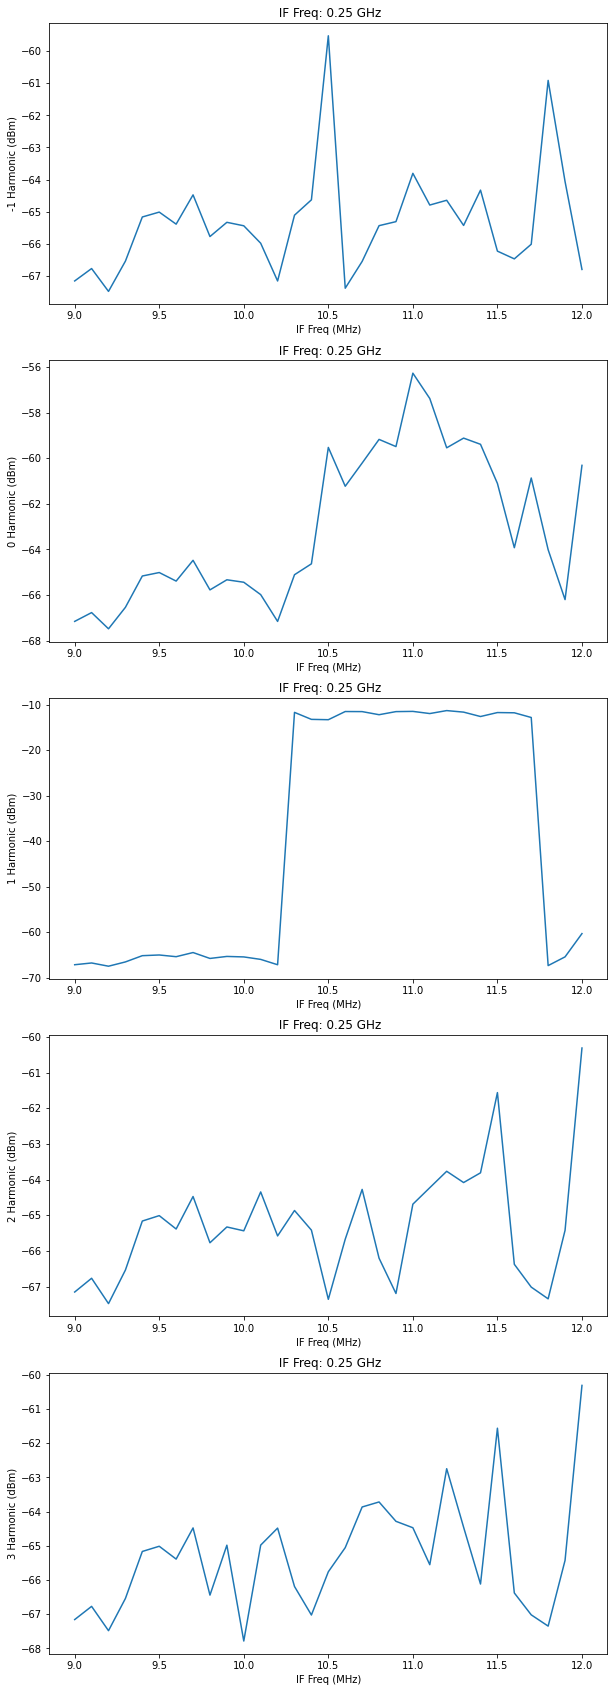

In [131]:
#Plotting power sweep
fig, axs = plt.subplots(5, 1, figsize=(10, 30))

for i in range(5):
    axs[i].plot(lo_freqs/1E9, harms[:, i])
    axs[i].set(xlabel='LO Freq (GHz)', ylabel=str(i-1) + ' Harmonic (dBm)', title=' IF Freq: ' + str(if_freq/1E9) + ' GHz')

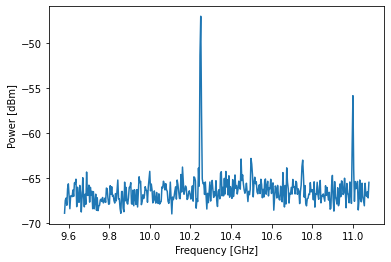

In [142]:
sa.plot_trace()

In [136]:
mw_client.set_freq(12E9)